In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(1000, 750, 3)


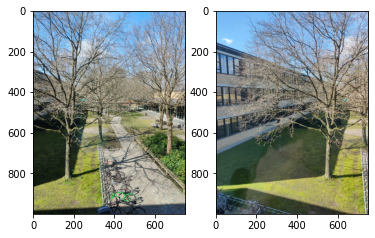

In [238]:
# Exercise 10.1

img1 = cv2.imread('week10/im1.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('week10/im2.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img1)
fig.add_subplot(1,2,2)
plt.imshow(img2)
print(img1.shape)

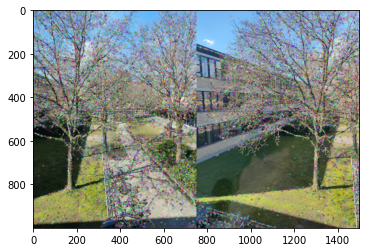

In [239]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)


img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:1],None)

plt.imshow(img3)

In [162]:
print(matches[0].trainIdx)
print(kp1[0].pt)


4515
(2.400566339492798, 201.77272033691406)


In [163]:
def CrossOp(p):
    return np.array([[0,-p[2],p[1]],
                    [p[2],0,-p[0]],
                    [-p[1],p[0],0]])

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def get_b(q1,q2):
    B = np.kron(q2[:,0], CrossOp(q1[:,0]))
    for i in range(1,len(q1.T)):
        B_temp = np.kron(q2[:,i], CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    return B

def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return np.linalg.inv(T1)@H.T@T2

In [164]:
# Exercise 10.2

'''
def RANSAC_initial(points, tau,p):
    max_inliers = 0
    max_inliers_line = np.array([0,0,0])
    n_points = points.shape[1]
    epsilon = 1
    N = np.ceil(np.log(1-p)/(np.log((1-((1-epsilon)**n_points)))))
    print(N)
    count = 0
    while count < N:
        p1,p2 = draw_2_points(points)
        line = homogeneous_line(p1,p2)
        inliers = consensus(line,points,tau)
        if inliers > max_inliers:
            max_inliers = inliers
            max_inliers_line = line
            epsilon = 1 - (max_inliers/n_points)
            N = np.ceil(np.log(1-p)/(np.log((1-(1-epsilon)**n_points))))
        count += 1
    return max_inliers_line, max_inliers


def RANSAC(points,tau,p):
    initial_guess, inliers = RANSAC_initial(points,tau,p)
    points_inliers = np.zeros((2,inliers))
    count = 0
    for point in points.T:
        if inline_point(initial_guess,point,tau):
            points_inliers[:,count] = point
            count += 1
    pca_line1 = pca_line(points_inliers)
    final_line = np.array([pca_line1[0][0],pca_line1[1][0],pca_line1[2][0]])
    return final_line
'''
def draw_4_points(points1,points2):
    n = points1.shape[0]
    i_1 = np.random.randint(0,n)
    idx = [i_1]
    p = np.zeros((4,3))
    q = np.zeros((4,3))
    p[0] = points1[i_1,:]
    q[0] = points2[i_1,:]
    i_2 = i_1
    count = 1
    while count < 4:
        while i_2 in idx:
            i_2 = np.random.randint(0,n)
        idx.append(i_2)
        
        p[count] = points1[i_2,:]
        q[count] = points2[i_2,:]
        count += 1

    return p,q

def approx_dist(h_est,p1,p2):
    #print(h_est)
    sum_1 = np.linalg.norm(((h_est@p2)[:-1]/(h_est@p2)[-1]) - (p1[:-1]/p1[-1]),2)**2
    sum_2 = np.linalg.norm(((np.linalg.inv(h_est)@p1)[:-1]/(np.linalg.inv(h_est)@p1)[-1]) - (p2[:-1]/p2[-1]),2)**2
    return sum_1+sum_2


def consensus(h_est,points1,points2,tau):
    inliers = 0
    for i in range(points1.shape[0]):
        dist = approx_dist(h_est,points1[i,:],points2[i,:])
        if dist < tau:
            inliers += 1
    return inliers
    

def RANSAC_v1(points1, points2,tau,N):
    points1_h = np.hstack([points1,np.ones((points1.shape[0],1))])
    points2_h = np.hstack([points2,np.ones((points2.shape[0],1))])
    max_inliers = 0
    max_inliers_hom = np.array([[0,0,0],[0,0,0],[0,0,0]])
    for i in range(N):
        p_h, q_h = draw_4_points(points1_h,points2_h)
        h_est = hest(p_h.T,q_h.T)
        inliers = consensus(h_est,points1_h,points2_h,tau)
        if inliers > max_inliers:
            max_inliers = inliers
            max_inliers_hom = h_est
    return max_inliers_hom


kp1 = np.asarray(kp1)
kp2 = np.asarray(kp2)

points1 = np.array([kp1[matches[i].queryIdx].pt for i in range(100)]).astype(int)
points2 = np.array([kp2[matches[i].trainIdx].pt for i in range(100)]).astype(int)
#p,q = draw_4_points(points1,points2)
#print(p.shape)
#print(q)
h_est = RANSAC_v1(points1,points2,20,200)
print(h_est)

[[ 6.32517355e-01  9.24223742e-03 -2.55964936e+02]
 [ 1.47493313e-01  5.75063920e-01 -8.10359988e+01]
 [ 3.27479726e-04 -6.07754144e-06  3.98312005e-01]]


In [39]:
print(kp1[matches[0].queryIdx])

<KeyPoint 000001A6B58B4270>


In [97]:
print(np.ones((1,4)))

[[1. 1. 1. 1.]]


In [115]:
print(points1.shape)

(100, 2)


In [240]:
# Exercise 10.3
def estHomographyRANSAC(kp1,des1,kp2,des2):
    bf = cv2.BFMatcher()
    kp1 = np.asarray(kp1)
    kp2 = np.asarray(kp2)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    points1 = np.array([kp1[matches[i].queryIdx].pt for i in range(100)]).astype(int)
    points2 = np.array([kp2[matches[i].trainIdx].pt for i in range(100)]).astype(int)
    H = RANSAC_v1(points1,points2,20,200)
    return H

H = estHomographyRANSAC(kp1,des1,kp2,des2)
print(H)


C:\Users\ct500\AppData\Local\Temp\ipykernel_19548\4019126468.py:60: RuntimeWarning: divide by zero encountered in true_divide
  sum_1 = np.linalg.norm(((h_est@p2)[:-1]/(h_est@p2)[-1]) - (p1[:-1]/p1[-1]),2)**2


[[-5.99630503e-01 -9.64446128e-03  2.42082052e+02]
 [-1.47855043e-01 -5.55003653e-01  8.21151000e+01]
 [-2.99429440e-04 -1.73581199e-06 -3.87058714e-01]]


In [241]:
# Exercise 10.4
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(np.ones(im.shape[:2], dtype=np.uint8), H, outSize)
    return imWarp, maskWarp

img1_warp,img1_mask = warpImage(img1, np.identity(3), [0,img1.shape[1]],[0,img1.shape[0]])
img2_warp, img2_mask = warpImage(img2, H, [-650,img2.shape[1]-400],[0,img2.shape[0]])




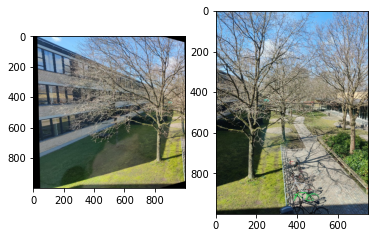

In [242]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img2_warp)
fig.add_subplot(1,2,2)
plt.imshow(img1_warp)

In [224]:
print(img1_warp.shape)
print(img2_warp.shape)

(1000, 750)
(1000, 1000)


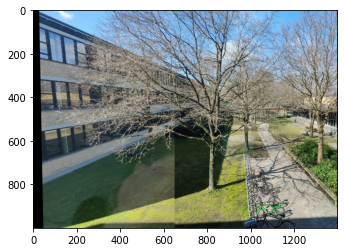

In [248]:
# Exercise 10.5

stiched_img = np.zeros((1000,650+750,3))
for i in range(stiched_img.shape[0]):
    for j in range(650):
        stiched_img[i,j] = img2_warp[i,j]
        
for i in range(stiched_img.shape[0]):      
    for j in range(650,650+img2.shape[1]):
        stiched_img[i,j] = img1_warp[i,j-650]
        


plt.imshow(stiched_img.astype(int))


